In [83]:
import imp
import uproot
import coffea
from coffea import hist
import numpy as np
import datasets
import seutils
import math

%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
imp.reload(datasets)

   INFO:2020-06-12 11:19:04:datasets:9 Logger datasets is already defined
   INFO:2020-06-12 11:19:04:datasets:42 Using tqdm notebook


<module 'datasets' from '/uscms_data/d3/klijnsma/semivis/flatntuplestudies/v0/datasets.py'>

## Initialize the datasets

Cache some events. We can't store all events in memory, but for testing it's convenient to have at least some events easy to access. From here on out, if use_cache == True, we're using this limited set of events for the sake of developing faster.

In [7]:
ttjets, qcd, wjets, zjets = datasets.init_bkgs(
    make_cache = True,
    cache_branches = [b'JetsAK15', b'JetsAK15_softDropMass', b'TriggerPass', b'MET', b'METPhi']
    )

   INFO:2020-06-12 11:19:07:datasets:173 Cached ~3.2 Mb (4946 entries, 5 branches)


   INFO:2020-06-12 11:19:08:datasets:173 Cached ~3.1 Mb (4826 entries, 5 branches)


   INFO:2020-06-12 11:19:10:datasets:173 Cached ~15.2 Mb (23932 entries, 5 branches)


   INFO:2020-06-12 11:19:14:datasets:173 Cached ~10.2 Mb (13177 entries, 5 branches)


   INFO:2020-06-12 11:19:15:datasets:173 Cached ~8.5 Mb (10883 entries, 5 branches)


   INFO:2020-06-12 11:19:15:datasets:173 Cached ~1.3 Mb (1597 entries, 5 branches)


   INFO:2020-06-12 11:19:24:datasets:173 Cached ~33.5 Mb (42699 entries, 5 branches)


   INFO:2020-06-12 11:19:29:datasets:173 Cached ~48.4 Mb (80000 entries, 5 branches)


   INFO:2020-06-12 11:19:38:datasets:173 Cached ~51.3 Mb (80000 entries, 5 branches)


   INFO:2020-06-12 11:19:45:datasets:173 Cached ~43.5 Mb (60000 entries, 5 branches)


   INFO:2020-06-12 11:19:58:datasets:173 Cached ~59.7 Mb (80000 entries, 5 branches)


   INFO:2020-06-12 11:20:09:datasets:173 Cached ~60.0 Mb (80000 entries, 5 branches)


   INFO:2020-06-12 11:20:12:datasets:173 Cached ~13.5 Mb (18000 entries, 5 branches)


   INFO:2020-06-12 11:20:17:datasets:173 Cached ~22.5 Mb (30000 entries, 5 branches)


   INFO:2020-06-12 11:20:26:datasets:173 Cached ~31.6 Mb (42000 entries, 5 branches)


   INFO:2020-06-12 11:20:38:datasets:173 Cached ~31.6 Mb (42000 entries, 5 branches)


   INFO:2020-06-12 11:20:45:datasets:173 Cached ~32.2 Mb (42940 entries, 5 branches)


   INFO:2020-06-12 11:20:48:datasets:173 Cached ~12.0 Mb (16000 entries, 5 branches)


   INFO:2020-06-12 11:20:51:datasets:173 Cached ~17.9 Mb (24000 entries, 5 branches)


   INFO:2020-06-12 11:21:11:datasets:173 Cached ~94.1 Mb (156056 entries, 5 branches)


   INFO:2020-06-12 11:21:23:datasets:173 Cached ~62.8 Mb (103601 entries, 5 branches)


   INFO:2020-06-12 11:21:36:datasets:173 Cached ~85.5 Mb (133144 entries, 5 branches)


   INFO:2020-06-12 11:21:39:datasets:173 Cached ~10.0 Mb (13883 entries, 5 branches)


   INFO:2020-06-12 11:21:40:datasets:173 Cached ~6.2 Mb (8295 entries, 5 branches)


   INFO:2020-06-12 11:21:48:datasets:173 Cached ~26.4 Mb (34993 entries, 5 branches)


   INFO:2020-06-12 11:21:52:datasets:173 Cached ~20.6 Mb (27195 entries, 5 branches)


   INFO:2020-06-12 11:22:01:datasets:173 Cached ~41.2 Mb (54172 entries, 5 branches)


   INFO:2020-06-12 11:22:23:datasets:173 Cached ~157.4 Mb (259978 entries, 5 branches)


   INFO:2020-06-12 11:22:52:datasets:173 Cached ~192.1 Mb (302793 entries, 5 branches)


   INFO:2020-06-12 11:22:52:datasets:173 Cached ~0.0 b (0 entries, 5 branches)


   INFO:2020-06-12 11:23:04:datasets:173 Cached ~68.8 Mb (93720 entries, 5 branches)


   INFO:2020-06-12 11:23:12:datasets:173 Cached ~31.0 Mb (41600 entries, 5 branches)


   INFO:2020-06-12 11:23:19:datasets:173 Cached ~38.8 Mb (51548 entries, 5 branches)


   INFO:2020-06-12 11:23:23:datasets:173 Cached ~13.5 Mb (17926 entries, 5 branches)


### Signal dataset

In [8]:
signal = datasets.Dataset(
    'mZ300',
    seutils.ls_root('root://cmseos.fnal.gov//store/user/klijnsma/semivis/treemaker_sig_Jun02'),
    is_signal = True,
    bkgname = 'mz300'
    )
signal.xs = 640. * 0.00075 * 5 # numbers from Sara
signal.cache_branches(
    branches = [b'JetsAK15', b'JetsAK15_softDropMass', b'TriggerPass', b'MET', b'METPhi'],
    n_files = 5
    )

   INFO:2020-06-12 11:23:26:datasets:173 Cached ~2.9 Mb (3763 entries, 5 branches)


## Basic softdrop mass, no cuts

Let's make a basic histogram of the softdrop mass of AK15 jets for signal and background

In [23]:
hist_msd_split = hist.Hist(
    'Count',
    hist.Cat('dataset', 'Dataset'),
    hist.Bin('msd', r'$m_{SD}$ for AK15', 100, 0., 500.)
    )

# Fill the bkg
for arrays, weight, dataset in datasets.iterate_bkg([ttjets, qcd, wjets, zjets]):
    hist_msd_split.fill(
        dataset = 'total_bkg',
        msd = arrays[b'JetsAK15_softDropMass'].flatten(),
        weight = weight
        )
    hist_msd_split.fill(
        dataset =  dataset.bkgname,
        msd = arrays[b'JetsAK15_softDropMass'].flatten(),
        weight = weight
        )
    
# Fill the signal
for arrays, weight, dataset in datasets.iterate_sig([signal]):
    hist_msd_split.fill(
        dataset = dataset.name,
        msd = arrays[b'JetsAK15_softDropMass'].flatten(),
        weight = weight
        )

In [26]:
def plot_msd_basic(hist_msd, ymin=0.1):
    fig = plt.figure(figsize=(6,6))
    ax = fig.gca()
    hist.plot1d(hist_msd, ax=ax)
    ax.set_ylim(ymin)
    ax.set_yscale('log')
    ax.set_ylabel('Cross section')

/uscms_data/d3/klijnsma/miniconda3/envs/condaroot/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


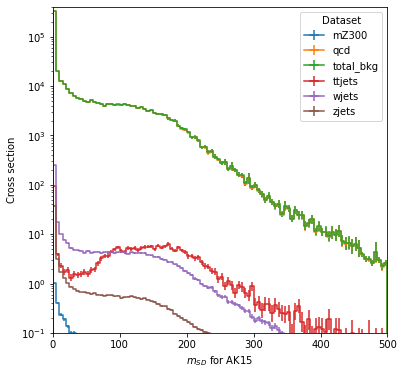

In [27]:
plot_msd_basic(hist_msd_split)

# Applying triggers and preselection

In [28]:
trigger_titles = datasets.get_trigger_titles()

In [10]:
def apply_trigger(arrays, triggers):
    """
    Given a structure `arrays` as given by uproot, applies triggers and returns a filtered arrays.
    The branch b'TriggerPass' must be in arrays
    """
    # Indices of the triggers we want to apply
    trigger_indices = np.array([ trigger_titles.index(trigger) for trigger in triggers ])
    trigger_decisions = arrays[b'TriggerPass']
    # Check, per event, if any of the triggers we want equals 1
    passes = (trigger_decisions[:,trigger_indices] == 1).any(axis=1)
    n_total = trigger_decisions.shape[0]
    n_pass = passes.nonzero()[0].shape[0]
    return { k : v[passes] for k, v in arrays.items() }, n_pass, n_total

In [42]:
def filter_zerojet_events(arrays):
    passes = (arrays[b'JetsAK15'].counts >= 1)
    return { k : v[passes] for k, v in arrays.items() }
    
def get_leading_jet(arrays):
    jets = arrays[b'JetsAK15']
    leading_jet = jets[jets.pt.argmax()]
    assert jets.shape[0] == leading_jet.shape[0]
    return leading_jet

def get_leading_jet_branch(arrays):
    arrays[b'JetsAK15_leading'] = get_leading_jet(arrays)

In [64]:
def calculate_mt(arrays, jets_branch=b'JetsAK15_leading'):
    metx = np.cos(arrays[b'METPhi']) * arrays[b'MET']
    mety = np.sin(arrays[b'METPhi']) * arrays[b'MET']
    mete = np.sqrt(metx**2 + mety**2)
    
    jets = arrays[jets_branch]
    jetsx = np.cos(jets.phi) * jets.pt
    jetsy = np.sin(jets.phi) * jets.pt
    jetse = np.sqrt(jets.mass**2 + jets.pt**2)
    
    mt = np.sqrt( (jetse + mete)**2 + (jetsx + metx)**2 + (jetsy + mety)**2 )
    return mt

def update_arrays_mtleadingjet(arrays):
    arrays[b'JetsAK15_leading'] = get_leading_jet(arrays)
    arrays[b'JetsAK15_MT'] = calculate_mt(arrays)
    arrays[b'JetsAK15_RT'] = arrays[b'MET'] / arrays[b'JetsAK15_MT']

In [13]:
def apply_preselection(arrays):    
    # Build the preselection
    preselection = (arrays[b'JetsAK15_RT'] > 0.15) & (arrays[b'JetsAK15_MT'] > 500.)
    preselection = preselection.flatten() # Make sure it's at event level, not leading-jet level
    arrays_postpreselection = { k : v[preselection] for k, v in arrays.items() }
    n_pass = arrays_postpreselection[b'JetsAK15_MT'].shape[0]
    return arrays_postpreselection, n_pass

Now here actually applying the triggers and preselection, and saving filtered events in histograms

In [48]:
triggers = [ 'HLT_AK8PFJet450_v', 'HLT_PFHT800_v' ]

hist_msd_raw = hist.Hist(
    'Count',
    hist.Cat('dataset', 'Dataset'),
    hist.Bin('msd', r'$m_{SD}$ for AK15', 50, 0., 500.)
    )
hist_msd_posttrigger = hist.Hist(
    'Count',
    hist.Cat('dataset', 'Dataset'),
    hist.Bin('msd', r'$m_{SD}$ for AK15', 50, 0., 500.)
    )
hist_msd_postpreselection = hist.Hist(
    'Count',
    hist.Cat('dataset', 'Dataset'),
    hist.Bin('msd', r'$m_{SD}$ for AK15', 50, 0., 500.)
    )
hist_mt_raw = hist.Hist(
    'Count',
    hist.Cat('dataset', 'Dataset'),
    hist.Bin('mt', r'$m_{T}$ for AK15 with MET', 50, 0., 2500.)
    )
hist_mt_posttrigger = hist.Hist(
    'Count',
    hist.Cat('dataset', 'Dataset'),
    hist.Bin('mt', r'$m_{T}$ for AK15 with MET', 50, 0., 2500.)
    )
hist_mt_postpreselection = hist.Hist(
    'Count',
    hist.Cat('dataset', 'Dataset'),
    hist.Bin('mt', r'$m_{T}$ for AK15 with MET', 50, 0., 2500.)
    )

# Keep track of trigger efficiency
n_pass_trigger = { key : 0 for key in ['ttjets', 'qcd', 'wjets', 'zjets', 'signal']}
n_pass_preselection = { key : 0 for key in ['ttjets', 'qcd', 'wjets', 'zjets', 'signal']}
n_total = { key : 0 for key in ['ttjets', 'qcd', 'wjets', 'zjets', 'signal']}


def fill_hists(iterator, is_bkg=True):
    for arrays, weight, dataset, bkgname in iterator:
        arrays = filter_zerojet_events(arrays)
        # Calculate the MT and RT
        arrays[b'JetsAK15_leading'] = get_leading_jet(arrays)
        arrays[b'JetsAK15_MT'] = calculate_mt(arrays)
        arrays[b'JetsAK15_RT'] = arrays[b'MET'] / arrays[b'JetsAK15_MT']
        
        # Label for the histogram
        name = bkgname if is_bkg else dataset.name

        # Fill the histogram before trigger
        hist_msd_raw.fill(dataset=name, msd=arrays[b'JetsAK15_softDropMass'].flatten(), weight=weight)
        hist_mt_raw.fill(dataset=name, mt=arrays[b'JetsAK15_MT'].flatten(), weight=weight)
        if is_bkg:
            hist_msd_raw.fill(dataset='total_bkg', msd=arrays[b'JetsAK15_softDropMass'].flatten(), weight=weight)
            hist_mt_raw.fill(dataset='total_bkg', mt=arrays[b'JetsAK15_MT'].flatten(), weight=weight)

        #__________________________
        # Trigger
        
        arrays_posttrigger, this_n_pass, this_n_total = apply_trigger(arrays, triggers)
        n_pass_trigger[name] += this_n_pass
        n_total[name] += this_n_total

        hist_msd_posttrigger.fill(dataset=name, msd=arrays_posttrigger[b'JetsAK15_softDropMass'].flatten(), weight=weight)
        hist_mt_posttrigger.fill(dataset=name, mt=arrays_posttrigger[b'JetsAK15_MT'].flatten(), weight=weight)
        if is_bkg:
            hist_msd_posttrigger.fill(dataset='total_bkg', msd=arrays_posttrigger[b'JetsAK15_softDropMass'].flatten(), weight=weight)
            hist_mt_posttrigger.fill(dataset='total_bkg', mt=arrays_posttrigger[b'JetsAK15_MT'].flatten(), weight=weight)

        #__________________________
        # Preselection

        arrays_postpreselection, this_n_pass = apply_preselection(arrays_posttrigger)
        n_pass_preselection[name] += this_n_pass

        hist_msd_postpreselection.fill(dataset=name, msd=arrays_postpreselection[b'JetsAK15_softDropMass'].flatten(), weight=weight)
        hist_mt_postpreselection.fill(dataset=name, mt=arrays_postpreselection[b'JetsAK15_MT'].flatten(), weight=weight)
        if is_bkg:
            hist_msd_postpreselection.fill(dataset='total_bkg', msd=arrays_postpreselection[b'JetsAK15_softDropMass'].flatten(), weight=weight)
            hist_mt_postpreselection.fill(dataset='total_bkg', mt=arrays_postpreselection[b'JetsAK15_MT'].flatten(), weight=weight)
    
fill_hists(iterate_bkg())
fill_hists(iterate_sig(is_bkg=False))

Using cached data (limited)
Using cached data (limited)


In [44]:
print('Trigger eff:')
for key in n_pass_trigger.keys():
    eff = float(n_pass_trigger[key]) / n_total[key]
    print(
        'Efficiency for {0:6}: {1:.3f}  ({2}/{3})'
        .format(key, eff, n_pass_trigger[key], n_total[key])
        )

Trigger eff:
Efficiency for ttjets: 0.753  (60988/81002)
Efficiency for qcd   : 0.631  (297439/471743)
Efficiency for wjets : 0.495  (101353/204758)
Efficiency for zjets : 0.294  (102348/347676)
Efficiency for signal: 0.675  (2541/3762)


In [45]:
print('Preselection + trigger eff:')
for key in n_pass_preselection.keys():
    eff = float(n_pass_preselection[key]) / n_total[key]
    print(
        'Efficiency for {0:6}: {1:.3f}  ({2}/{3})'
        .format(key, eff, n_pass_preselection[key], n_total[key])
        )

Preselection + trigger eff:
Efficiency for ttjets: 0.107  (8634/81002)
Efficiency for qcd   : 0.015  (7077/471743)
Efficiency for wjets : 0.111  (22735/204758)
Efficiency for zjets : 0.154  (53701/347676)
Efficiency for signal: 0.297  (1116/3762)


/uscms_data/d3/klijnsma/miniconda3/envs/condaroot/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/uscms_data/d3/klijnsma/miniconda3/envs/condaroot/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/uscms_data/d3/klijnsma/miniconda3/envs/condaroot/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


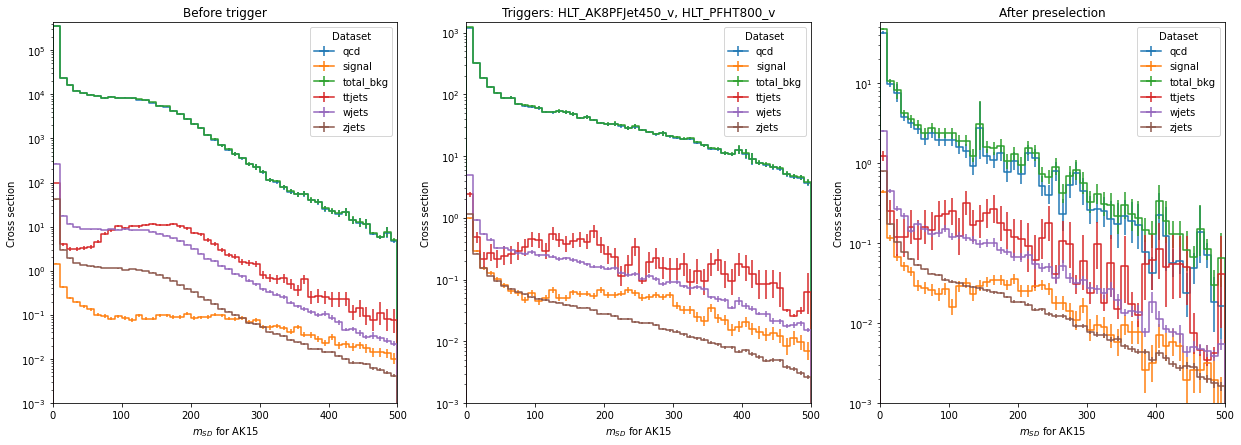

In [51]:
def plot_msd_posttrigger():
    ymin = 0.001
    fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(21,7))
    ax = axs[0]
    hist.plot1d(hist_msd_raw, ax=ax)
    ax.set_ylim(ymin)
    ax.set_yscale('log')
    ax.set_ylabel('Cross section')
    ax.set_title('Before trigger')
    ax = axs[1]
    hist.plot1d(hist_msd_posttrigger, ax=ax)
    ax.set_ylim(ymin)
    ax.set_yscale('log')
    ax.set_ylabel('Cross section')
    ax.set_title('Triggers: {0}'.format(', '.join(triggers)))
    ax = axs[2]
    hist.plot1d(hist_msd_postpreselection, ax=ax)
    ax.set_ylim(ymin)
    ax.set_yscale('log')
    ax.set_ylabel('Cross section')
    ax.set_title('After preselection')
plot_msd_posttrigger()

/uscms_data/d3/klijnsma/miniconda3/envs/condaroot/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/uscms_data/d3/klijnsma/miniconda3/envs/condaroot/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/uscms_data/d3/klijnsma/miniconda3/envs/condaroot/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


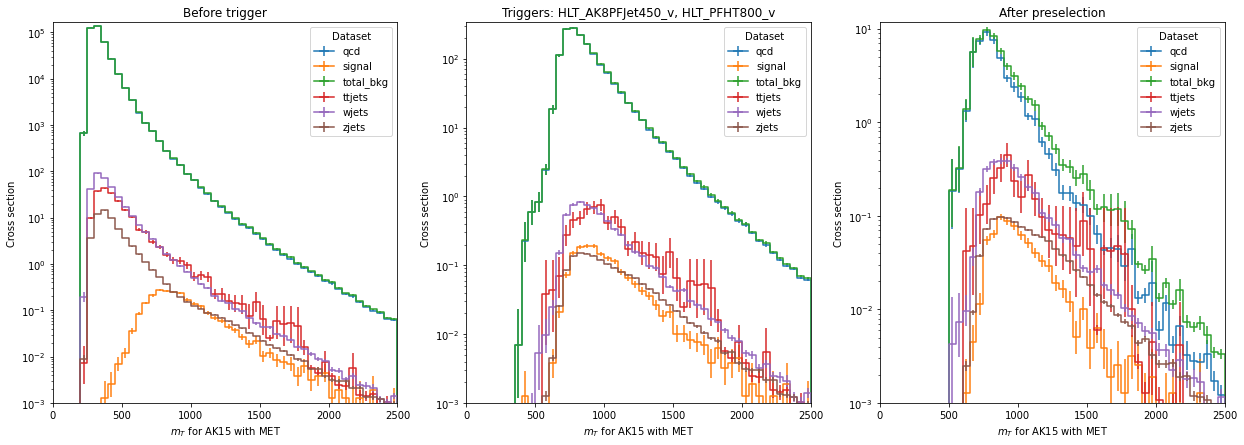

In [50]:
def plot_mt_posttrigger():
    ymin = 0.001
    fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(21,7))
    ax = axs[0]
    hist.plot1d(hist_mt_raw, ax=ax)
    ax.set_ylim(ymin)
    ax.set_yscale('log')
    ax.set_ylabel('Cross section')
    ax.set_title('Before trigger')
    ax = axs[1]
    hist.plot1d(hist_mt_posttrigger, ax=ax)
    ax.set_ylim(ymin)
    ax.set_yscale('log')
    ax.set_ylabel('Cross section')
    ax.set_title('Triggers: {0}'.format(', '.join(triggers)))
    ax = axs[2]
    hist.plot1d(hist_mt_postpreselection, ax=ax)
    ax.set_ylim(ymin)
    ax.set_yscale('log')
    ax.set_ylabel('Cross section')
    ax.set_title('After preselection')
plot_mt_posttrigger()

# Making a ROC curve

In [93]:
def get_eff(arrays_iterator, cut_function, cut_values):
    n_cuts = len(cut_values)
    n_total = np.zeros(n_cuts)
    n_pass = np.zeros(n_cuts)
    for arrays, weight, dataset in arrays_iterator:
        for i_cut, cut in enumerate(cut_values):
            this_n_pass, this_n_total = cut_function(arrays, cut)
            n_total[i_cut] += weight * this_n_total
            n_pass[i_cut] += weight * this_n_pass
    eff = np.divide(n_pass, n_total, out=np.zeros_like(n_pass), where=n_total!=0)
    return eff, n_pass, n_total
    
def roc_curve(sig_iterator, bkg_iterator, cut_function, cut_values, title=None):
    eff_sig, n_pass_sig, n_total_sig = get_eff(sig_iterator, cut_function, cut_values)
    eff_bkg, n_pass_bkg, n_total_bkg = get_eff(bkg_iterator, cut_function, cut_values)

    fig = plt.figure(figsize=(8,8))
    ax = fig.gca()
    ax.plot([0.0,1.0], [0.0,1.0], linestyle='--', color='xkcd:orange')
    ax.plot(eff_bkg, eff_sig, marker='o')
    ax.set_xlim(0.0, 1.05)
    ax.set_ylim(0.0, 1.05)
    ax.set_ylabel('Signal eff.')
    ax.set_xlabel('Bkg eff.')
    if title: ax.set_title(title)

    ndec = lambda number: 0 if abs(number) >= 100. else ( 1 if abs(number) >= 10. else 2 )
    for i in range(len(cut_values)):
        ax.text(
            eff_bkg[i], eff_sig[i],
            '{0:.{ndec}f}'.format(cut_values[i], ndec=ndec(cut_values[i]))
            )

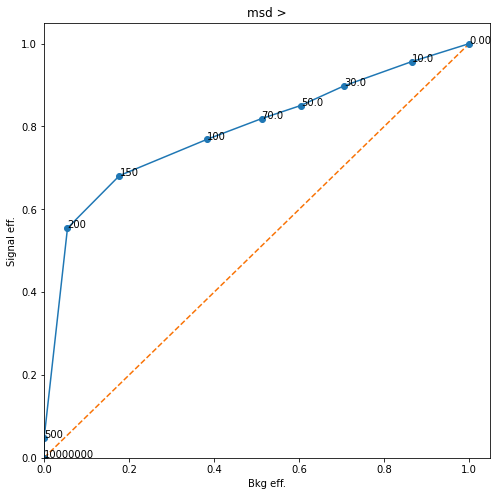

In [100]:
def msd_cut_function(arrays, cut):
    arrays = filter_zerojet_events(arrays)
    n_pass = (arrays[b'JetsAK15_softDropMass'] > cut).any().sum()
    n_total = (arrays[b'JetsAK15_softDropMass'] > 0.0).any().sum()
    return n_pass, n_total

roc_curve(
    datasets.iterate_sig([signal]),
    datasets.iterate_bkg([ttjets, qcd, wjets, zjets]),
    msd_cut_function,
    [ 0.0, 10., 30., 50., 70., 100., 150., 200., 500., 1e7 ],
    title = 'msd >'
    )

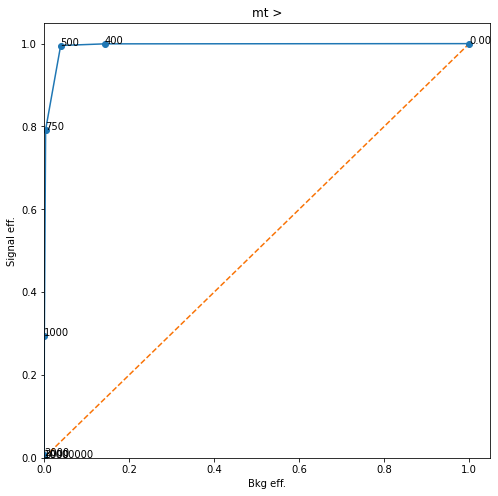

In [103]:
def mt_cut_function(arrays, cut):
    arrays = filter_zerojet_events(arrays)
    update_arrays_mtleadingjet(arrays)
    n_pass = (arrays[b'JetsAK15_MT'] > cut).any().sum()
    n_total = (arrays[b'JetsAK15_MT'] > 0.0).any().sum()
    return n_pass, n_total

roc_curve(
    datasets.iterate_sig([signal]),
    datasets.iterate_bkg([ttjets, qcd, wjets, zjets]),
    mt_cut_function,
    [ 0.0, 400., 500., 750., 1000., 2000., 3000., 1e7 ],
    title = 'mt >'
    )

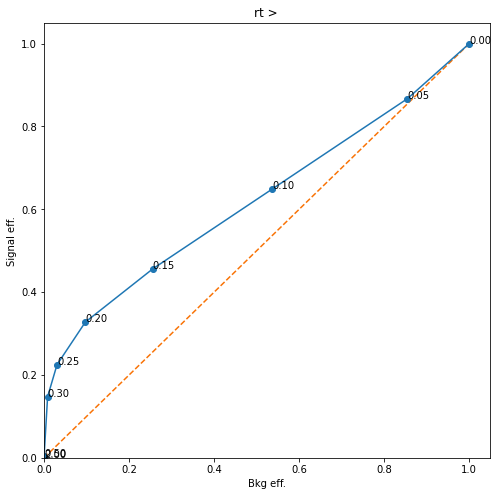

In [95]:
def rt_cut_function(arrays, cut):
    arrays = filter_zerojet_events(arrays)
    update_arrays_mtleadingjet(arrays)
    selection = arrays[b'JetsAK15_RT'] > cut
    n_total = arrays[b'JetsAK15'].shape[0]
    n_pass = selection.any().sum()
    return n_pass, n_total

roc_curve(
    datasets.iterate_sig([signal]),
    datasets.iterate_bkg([ttjets, qcd, wjets, zjets]),
    rt_cut_function,
    [ 0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.50, 2.0],
    title = 'rt > '
    )

In [ ]:
def rt_cut_function(arrays, cut):
    arrays = filter_zerojet_events(arrays)
    update_arrays_mtleadingjet(arrays)
    selection = arrays[b'JetsAK15_RT'] > cut
    n_total = arrays[b'JetsAK15'].shape[0]
    n_pass = selection.any().sum()
    return n_pass, n_total

roc_curve(
    datasets.iterate_sig([signal]),
    datasets.iterate_bkg([ttjets, qcd, wjets, zjets]),
    rt_cut_function,
    [ 0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.50, 2.0],
    title = 'rt > '
    )

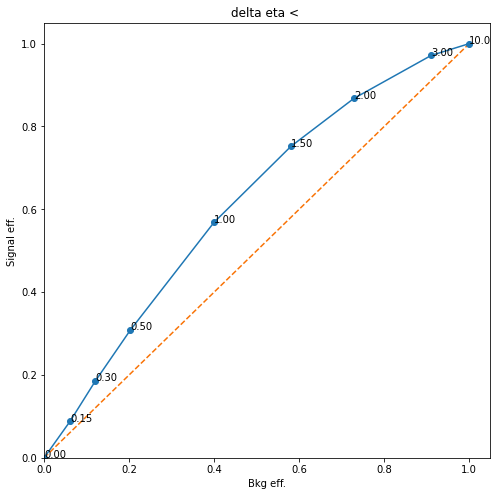

In [98]:
def get_deltaeta(arrays):
    jets = arrays[b'JetsAK15']
    # Only events with at least two jets
    jets = jets[jets.counts >= 2]
    # Throw away jets other than the first 2
    leading = jets[:,0]
    subleading = jets[:,1]
    delta_eta = np.abs(leading.eta - subleading.eta)
    return delta_eta

def deltaeta_cut_function(arrays, cut):
    n_total = (arrays[b'JetsAK15'].counts >= 2).sum()
    delta_eta = get_deltaeta(arrays)
    selection = delta_eta < cut
    n_pass = selection.sum()
    return n_pass, n_total

roc_curve(
    datasets.iterate_sig([signal]),
    datasets.iterate_bkg([ttjets, qcd, wjets, zjets]),
    deltaeta_cut_function,
    [ 0.0, 0.15, 0.30, 0.50, 1.0, 1.5, 2.0, 3.0, 10.],
    title = 'delta eta < '
    )

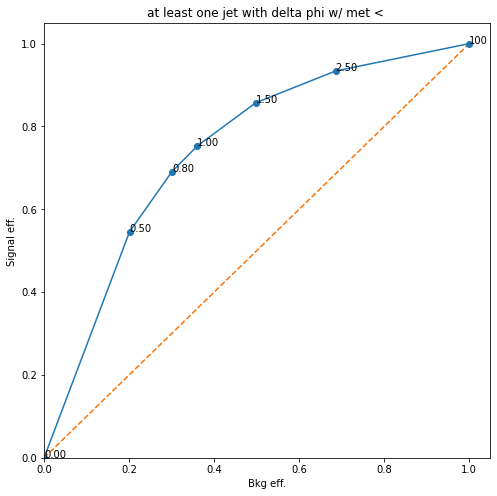

In [107]:
def get_dphimet(arrays):
    phi_jet = arrays[b'JetsAK15'].phi
    phi_met = arrays[b'METPhi']
    dphi = np.abs(phi_jet - phi_met)
    return dphi

def dphimet_cut_function(arrays, cut):
    # Only events with at least one jet
    arrays = filter_zerojet_events(arrays)
    n_total = arrays[b'JetsAK15'].shape[0]
    dphi = get_dphimet(arrays)    
    selection = (dphi < cut).any()
    n_pass = selection.sum()
    return n_pass, n_total

roc_curve(
    datasets.iterate_sig([signal]),
    datasets.iterate_bkg([ttjets, qcd, wjets, zjets]),
    dphimet_cut_function,
    [ 0.0, 0.5, 0.8, 1.0, 1.5, 2.5, 100.],
    title = 'at least one jet with delta phi w/ met < '
    )